In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
from tqdm import tqdm_notebook
from torchvision import transforms
import torchvision
import torch.optim as optim
from torch.optim import lr_scheduler

# RESULT submission scored 0.99367

In [86]:
train = pd.read_csv("train.csv",dtype = np.float32)
test = pd.read_csv("test.csv", dtype = np.float32)

In [ ]:
transform=transforms.Compose([ transforms.ToPILImage(), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=0.5)])

In [137]:
class DataSetMnist(torch.utils.data.Dataset):
    def __init__(self,data,transform=None):
        self.data=data
        self.transform=transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        item=self.data.iloc[index]
       
        image=item[1:].values.astype(np.uint8).reshape((28,28))
        label=item[0]
        if self.transform != None:
                image=self.transform(image)
        return image, label
       

In [154]:
class DataSetMnistTest(DataSetMnist):
    def __getitem__(self,index):
        item=self.data.iloc[index]
       
        image=item.values.astype(np.uint8).reshape((28,28))
        if self.transform != None:
                image=self.transform(image)
        return image

In [156]:
train_df=DataSetMnist(train,transform)
test_df=DataSetMnistTest(test,transform)

In [157]:
data_train,data_valid= torch.utils.data.random_split(train_df,[31500, 10500])

In [198]:
train_loader = DataLoader(data_train, batch_size = 100, shuffle = False)
test_loader = DataLoader(data_valid, batch_size = 100, shuffle = False)
test_result = DataLoader(test_df, batch_size = 100, shuffle = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


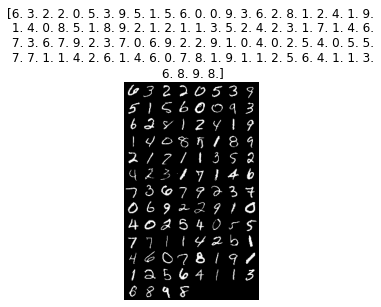

In [159]:
train_iter = iter(train_loader)
images, labels = train_iter.next()
grid = torchvision.utils.make_grid(images)
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.numpy());


In [160]:
from torchvision import transforms, datasets

In [161]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.features=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(32,32,kernel_size=3,padding=1,stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            nn.Conv2d(32,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(64,64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)                
          
            
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(64*7*7,512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512,10)
        )
        for m in self.features.children():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
        for m in self.classifier.children():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def forward(self,x):
        x=self.features(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        return x

In [13]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.003)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

<ipython-input-11-cbcfb290e906>:47: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


In [ ]:
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
exp_lr_scheduler.step()
for epoch in range(50):
    for i, (images,labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs=model(images)
        loss=error(outputs,labels.type(torch.LongTensor))
        loss.backward()
        optimizer.step()
        count += 1
        if count % 50 == 0:
            total = 0
            correct = 0
            for images, labels in test_loader:
                model.eval()
                outputs = model(images)
                total += labels.shape[0]
                predicted = torch.max(outputs.data,1)[1]
                correct += (predicted == labels).sum()
            accuracy=100 * correct /float( total)
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            print('Iteration {}, loss {}, accuracy {}'.format(count,loss.data,accuracy))

In [25]:
torch.save(model.state_dict(), 'mytraining.pt')

In [211]:
def predict(data):
    test_pred = torch.LongTensor()
    model.eval()
    for image in data:
        outputs=model(image)
        pred = torch.max(outputs.data,1)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
    return test_pred

In [ ]:
result=predict(test_result)

In [61]:
dt_result=pd.DataFrame(np.c_[np.arange(1,len(result)+1),result.numpy()], columns= ["ImageId","Label"])
dt_result.to_csv('res3.csv',index=False)